In [33]:
import os
import xml.etree.ElementTree as et
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import math
import sys
import statistics
import pandas as pd

from pathlib import Path
import os
from glob import glob
#import data_eng.az_proc as ap

In [34]:
parent_dir = '/home/jovyan/work/Test'
anno_dir = "chips_positive_xml"
img_ids = "img_ids.txt"

In [3]:
#fix truncated/difficult after updating corrected labels 
def area_and_aspect_ratio(parent_dir, img_ids, anno_dir, keep_difficult = True, bbox_remove = 10):       
    """
    for each img, parse the annotations in a format readable for pytorch
    argument: the parent directory and subdirectory containing the image; the imageid for the image of interest; the label map
    returns: a dictionary containing the bounding boxes, labels, and difficults
    """
    with open(os.path.join(parent_dir, img_ids)) as f:
        ids = f.read().splitlines()

    #Initial variables to count the number of objects in each category (set to zero)
    area_dict = {"closed_roof_tank": [], "narrow_closed_roof_tank": [], "external_floating_roof_tank": [], "spherical_tank":[], 
                 "sedimentation_tank":[], "water_tower": [], "undefined_object": []}
    area_sqrt_dict = {"closed_roof_tank": [], "narrow_closed_roof_tank": [], "external_floating_roof_tank": [], "spherical_tank":[], 
                 "sedimentation_tank":[], "water_tower": [], "undefined_object": []}
    aspect_ratio_dict = {"closed_roof_tank": [], "narrow_closed_roof_tank": [], "external_floating_roof_tank": [], "spherical_tank":[], 
                 "sedimentation_tank":[], "water_tower": [], "undefined_object": []} #width to height
    for id in ids:
        tree = et.parse(os.path.join(parent_dir, anno_dir, id +".xml"))
        root = tree.getroot()
        for object in root.iter('object'):
            bbox = object.find('bndbox')
            xmax = float(bbox.find('xmax').text)
            xmin = float(bbox.find('xmin').text)
            width = xmax - xmin
            ymax = float(bbox.find('ymax').text)
            ymin = float(bbox.find('ymin').text)
            height = ymax - ymin
            object.find('bndbox')
            area = width * height
            area_sqrt = math.sqrt(area)
            remove_bbox = (xmax == xmin) | (ymax == ymin) | (area < bbox_remove**2)
            if remove_bbox:
                #print("remove small")
                continue
            elif (object.find('truncated').text == "1") & (not keep_difficult):
                #print("remove truncated")
                continue
            elif (object.find('difficult').text == "1") & (not keep_difficult):
                #print("remove difficult")
                continue
            elif object.find("name").text in area_dict:
                area_dict[object.find("name").text].append(area)
                area_sqrt_dict[object.find("name").text].append(area_sqrt)
                aspect_ratio_dict[object.find("name").text].append(float(width) / float(height))
    return area_dict, area_sqrt_dict, aspect_ratio_dict

In [57]:
#fix truncated/difficult after updating corrected labels 
def area_and_aspect_ratio(parent_dir, img_ids, anno_dir, keep_difficult = True, bbox_remove = 10):       
    """
    for each img, parse the annotations in a format readable for pytorch
    argument: the parent directory and subdirectory containing the image; the imageid for the image of interest; the label map
    returns: a dictionary containing the bounding boxes, labels, and difficults
    """

    #Initial variables to count the number of objects in each category (set to zero)
    area_dict = {"closed_roof_tank": [], "narrow_closed_roof_tank": [], "external_floating_roof_tank": [], "spherical_tank":[], 
                 "sedimentation_tank":[], "water_tower": [], "undefined_object": []}
    area_sqrt_dict = {"closed_roof_tank": [], "narrow_closed_roof_tank": [], "external_floating_roof_tank": [], "spherical_tank":[], 
                 "sedimentation_tank":[], "water_tower": [], "undefined_object": []}
    aspect_ratio_dict = {"closed_roof_tank": [], "narrow_closed_roof_tank": [], "external_floating_roof_tank": [], "spherical_tank":[], 
                 "sedimentation_tank":[], "water_tower": [], "undefined_object": []} #width to height
    
    width_dict = {"closed_roof_tank": [], "narrow_closed_roof_tank": [], "external_floating_roof_tank": [], "spherical_tank":[], 
                 "sedimentation_tank":[], "water_tower": [], "undefined_object": []}
    truncated_difficult = {"truncated_difficult": []} #width to height
    counter = 0
    for id in img_ids:
        tree = et.parse(os.path.join(parent_dir, anno_dir, id))
        root = tree.getroot()
        for object in root.iter('object'):
            counter += 1
            bbox = object.find('bndbox')
            xmax = float(bbox.find('xmax').text)
            xmin = float(bbox.find('xmin').text)
            width = xmax - xmin
            ymax = float(bbox.find('ymax').text)
            ymin = float(bbox.find('ymin').text)
            height = ymax - ymin
            object.find('bndbox')
            area = width * height
            area_sqrt = math.sqrt(area)
            remove_bbox = (xmax == xmin) | (ymax == ymin) | (area < bbox_remove**2)
            if remove_bbox:
                #print("remove small")
                continue
            elif (object.find('truncated').text == "1") & (keep_difficult):
                #print("remove truncated")
                truncated_difficult["truncated_difficult"].append(1)
                continue
            elif (object.find('difficult').text == "1") & (keep_difficult):
                #print("remove difficult")
                truncated_difficult["truncated_difficult"].append(1)
                continue
            elif object.find("name").text in area_dict:
                width_dict[object.find("name").text].append(width)
                height_dict[object.find("name").text].append(height)
                area_dict[object.find("name").text].append(area)
                area_sqrt_dict[object.find("name").text].append(area_sqrt)
                aspect_ratio_dict[object.find("name").text].append(float(width) / float(height))
    return width_dict, height_dict, area_dict, area_sqrt_dict, aspect_ratio_dict, truncated_difficult, counter


In [58]:
parent_directory = "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//"    
chip_positive = os.path.join(parent_directory, "complete_dataset/archive/chips_positive_xml")
chip_positive_list_dir = os.listdir(chip_positive)
#keep_difficult_input = [False, False]
width_dict, height_dict, area_dict, area_sqrt_dict, aspect_ratio_dict,truncated_difficult, counter = area_and_aspect_ratio(parent_directory, 
                                                                                              chip_positive_list_dir,
                                                                                              chip_positive, keep_difficult = True,
                                                                                              bbox_remove = 0)

In [59]:
len(truncated_difficult["truncated_difficult"]) / counter

0.17464255910987483

Plot Areas

In [37]:
box_remove_input = [0,0]
names = ["All Objects", "All Objects (Excluding Truncated and Difficult Objects)"]

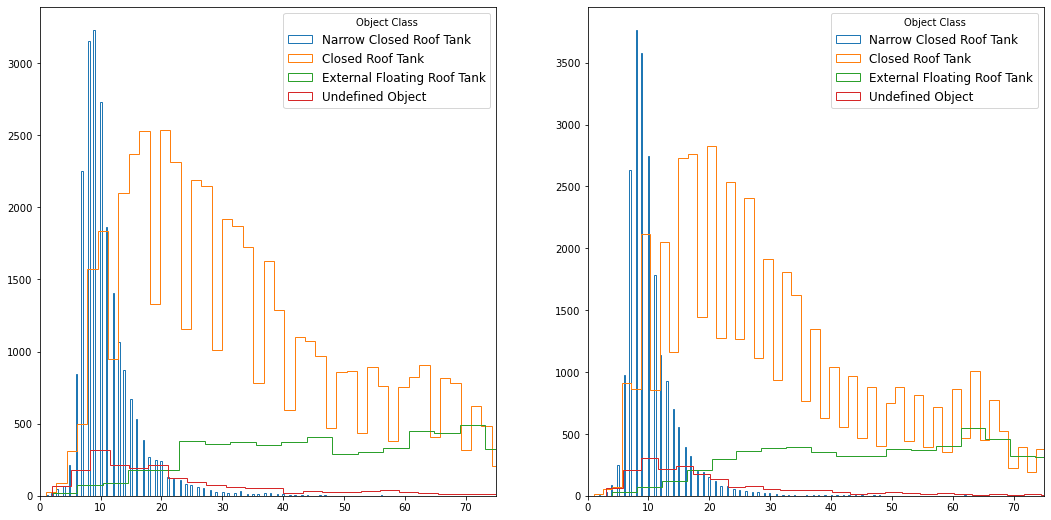

In [38]:
fig, ax = plt.subplots(1,2, figsize=(18,9))
ax[0].set_xlim(0,75)

ax[0].hist(width_dict["narrow_closed_roof_tank"],  bins='auto', stacked=True,fill=False,histtype='step', label = "Narrow Closed Roof Tank")
ax[0].hist(width_dict["closed_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Closed Roof Tank")                                                    
ax[0].hist(width_dict["external_floating_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "External Floating Roof Tank")                        
ax[0].hist(width_dict["undefined_object"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Undefined Object")  

ax[1].set_xlim(0,75)
\
ax[1].hist(height_dict["narrow_closed_roof_tank"],  bins='auto', stacked=True,fill=False,histtype='step', label = "Narrow Closed Roof Tank")
ax[1].hist(height_dict["closed_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Closed Roof Tank")                                                    
ax[1].hist(height_dict["external_floating_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "External Floating Roof Tank")                        
ax[1].hist(height_dict["undefined_object"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Undefined Object")  
# Plot formatting
ax[0].legend(prop={'size': 12}, title = 'Object Class')
ax[1].legend(prop={'size': 12}, title = 'Object Class')

counter += 1
plt.show()

False 0
False 0


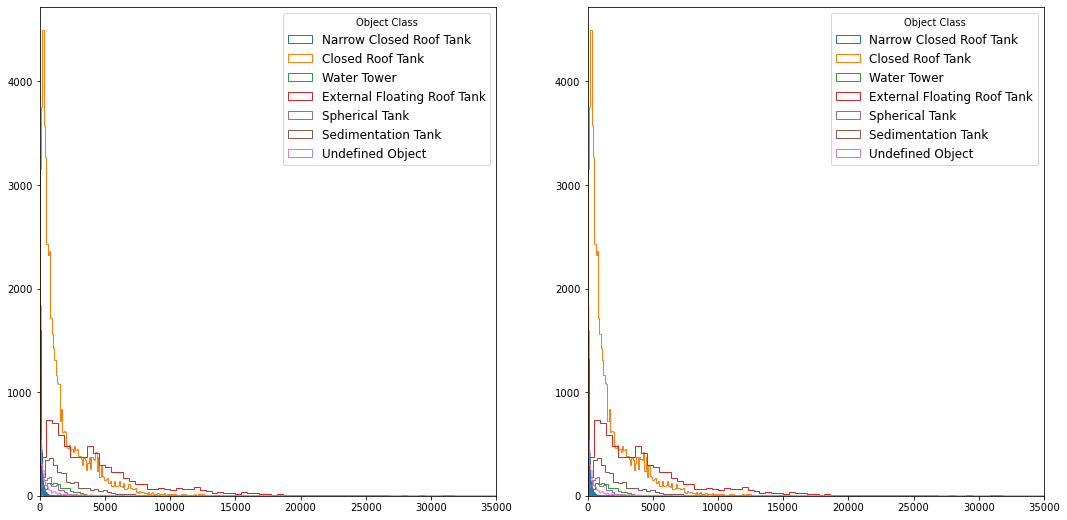

In [39]:
fig, axes = plt.subplots(1,2, figsize=(18,9))
counter = 0
for name, ax in zip(names, axes.flatten()):
    print(keep_difficult_input[counter], box_remove_input[counter])
    # Draw the density plot
    #ax.set_xscale('log')
    ax.set_xlim(0,35000)
    ax.hist(area_dict["narrow_closed_roof_tank"],  bins='auto', stacked=True,fill=False,histtype='step', label = "Narrow Closed Roof Tank")
    ax.hist(area_dict["closed_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Closed Roof Tank")  
                           
    ax.hist(area_dict["water_tower"],  bins='auto', stacked=True, fill=False,  histtype='step' ,label = "Water Tower")  
                           
    ax.hist(area_dict["external_floating_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "External Floating Roof Tank") 
                           
    ax.hist(area_dict["spherical_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Spherical Tank") 
                           
    ax.hist(area_dict["sedimentation_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Sedimentation Tank")             
    ax.hist(area_dict["undefined_object"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Undefined Object")  
    # Plot formatting
    ax.legend(prop={'size': 12}, title = 'Object Class')
    counter += 1
plt.show()

True 0
False 0


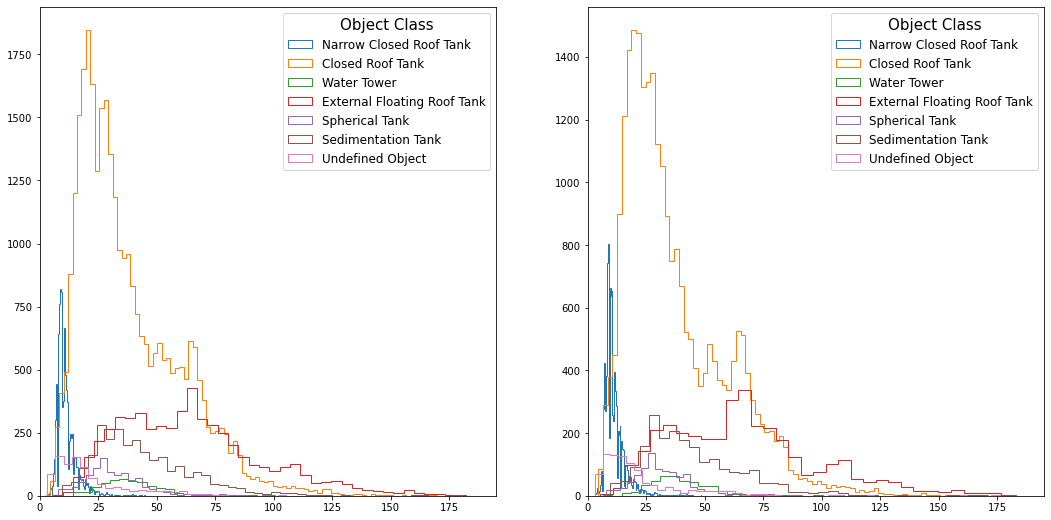

In [6]:
fig, axes = plt.subplots(1,2, figsize=(18,9))
counter = 0
for name, ax in zip(names, axes.flatten()):
    print(keep_difficult_input[counter], box_remove_input[counter])
    # Draw the density plot
    #ax.set_xscale('log')
    ax.set_xlim(0,195)
    ax.hist(area_sqrt_dict["narrow_closed_roof_tank"],  bins='auto', stacked=True,fill=False,histtype='step', label = "Narrow Closed Roof Tank")
    ax.hist(area_sqrt_dict["closed_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Closed Roof Tank")  
                           
    ax.hist(area_sqrt_dict["water_tower"],  bins='auto', stacked=True, fill=False,  histtype='step' ,label = "Water Tower")  
                           
    ax.hist(area_sqrt_dict["external_floating_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "External Floating Roof Tank") 
                           
    ax.hist(area_sqrt_dict["spherical_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Spherical Tank") 
                           
    ax.hist(area_sqrt_dict["sedimentation_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Sedimentation Tank")             
    ax.hist(area_sqrt_dict["undefined_object"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Undefined Object")  
    # Plot formatting
    ax.legend(prop={'size': 12},fontsize=10, title_fontsize=15, title = 'Object Class')
    counter += 1
plt.show()

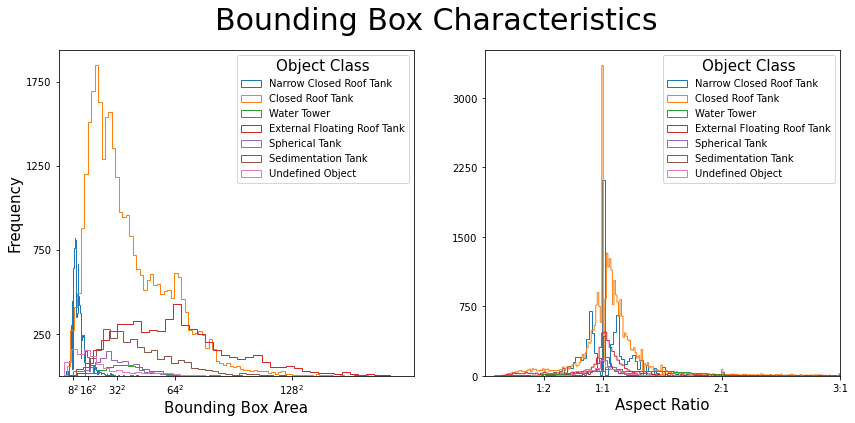

In [7]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
#ax[0,0].set_xscale('log')
ax[0].hist(area_sqrt["narrow_closed_roof_tank"],  bins='auto', stacked=True,fill=False,histtype='step', label = "Narrow Closed Roof Tank")
ax[0].hist(area_sqrt["closed_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Closed Roof Tank")  
ax[0].hist(area_sqrt["water_tower"],  bins='auto', stacked=True, fill=False,  histtype='step' ,label = "Water Tower")  
ax[0].hist(area_sqrt["external_floating_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "External Floating Roof Tank") 
ax[0].hist(area_sqrt["spherical_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Spherical Tank") 
ax[0].hist(area_sqrt["sedimentation_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Sedimentation Tank")             
ax[0].hist(area_sqrt["undefined_object"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Undefined Object")  
ax[0].legend(prop={'size': 10},fontsize=10, title_fontsize=15, title = 'Object Class')
ax[0].set_yticks(np.arange(250, 1751, step=500))
ax[0].set_ylabel('Frequency', fontsize=15)
ax[0].set_xlim(0,195)
xticks = [8,16,32,64,128]
ax[0].set_xticks(xticks)
labels = ['$8^{2}$','$16^{2}$','$32^{2}$','$64^{2}$','$128^{2}$']
ax[0].set_xticklabels((labels), fontsize=10) 
ax[0].set_xlabel('Bounding Box Area', fontsize=15)

ax[1].hist(aspect_ratio["narrow_closed_roof_tank"],  bins='auto', stacked=True,fill=False,histtype='step', label = "Narrow Closed Roof Tank")
ax[1].hist(aspect_ratio["closed_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Closed Roof Tank")                           
ax[1].hist(aspect_ratio["water_tower"],  bins='auto', stacked=True, fill=False,  histtype='step' ,label = "Water Tower")                           
ax[1].hist(aspect_ratio["external_floating_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "External Floating Roof Tank")                         
ax[1].hist(aspect_ratio["spherical_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Spherical Tank")                          
ax[1].hist(aspect_ratio["sedimentation_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Sedimentation Tank")             
ax[1].hist(aspect_ratio["undefined_object"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Undefined Object")  
ax[1].legend(prop={'size': 10},fontsize=10, title_fontsize=15, title = 'Object Class')
ax[1].set_yticks(np.arange(0, 3501, step=750))
#ax[1].set_ylabel('Frequency', fontsize=15)
ax[1].set_xlim(0,3)
xticks = [0.5,1,2,3]
ax[1].set_xticks(xticks)
labels = ['1:2','1:1','2:1','3:1']
ax[1].set_xticklabels((labels), fontsize=10) 
ax[1].set_xlabel('Aspect Ratio', fontsize=15)

# Plot formatting
plt.suptitle('Bounding Box Characteristics', fontsize= 30)
#plt.show()
plt.savefig('bounding_box_characteristics.png', transparent=True)

Dataframe of the Objects quared Area (Including Truncated/Difficult Objects)

In [8]:
area_dict, area_sqrt_dict, aspect_ratio_dict = area_and_aspect_ratio(parent_dir, img_ids, anno_dir, 
                                                                     keep_difficult = True, 
                                                                     bbox_remove = 0)

In [9]:
class_stats = []
class_ = []
for x in area_sqrt_dict:
    class_.append(x)
    class_stats.append([statistics.mean(area_sqrt_dict[x]), np.quantile(area_sqrt_dict[x], 0.05),
                        np.quantile(area_sqrt_dict[x],0.1), np.quantile(area_sqrt_dict[x],0.2),
                        np.quantile(area_sqrt_dict[x],0.5), np.quantile(area_sqrt_dict[x],0.95), len(area_sqrt_dict[x])])
class_stats = np.array(class_stats)

class_stats_df = pd.DataFrame(class_stats, columns = ['mean', '0.05 quantile', '0.1 quantile',
                                                      '0.2 quantile', '0.5 quantile',
                                                      '0.95 quantile', "number of objects"])
class_stats_df.insert(0, "class", class_, True)
class_stats_df

,class,mean,0.05 quantile,0.1 quantile,0.2 quantile,0.5 quantile,0.95 quantile,number of objects
0,closed_roof_tank,38.186596,13.000000,15.491933,19.493589,31.749016,79.943730,32174.0
1,narrow_closed_roof_tank,11.395661,7.000000,7.483315,8.485281,10.000000,20.000000,9568.0
2,external_floating_roof_tank,64.565695,23.874673,29.000000,36.943199,61.497967,123.333578,5465.0
3,spherical_tank,32.966692,13.656389,18.330303,22.414239,29.849623,58.487801,1039.0
4,sedimentation_tank,44.534129,18.544537,22.449944,26.996295,39.987498,83.509520,2760.0
5,water_tower,39.702275,20.706149,24.883709,28.495614,37.947332,63.131597,499.0
6,undefined_object,23.216913,5.477226,7.409426,9.486833,16.970563,60.497934,1030.0


Dataframe of the Objects squared Area (Excluding Truncated/Difficult Objects)

In [10]:
area_dict, area_sqrt_dict, aspect_ratio_dict = area_and_aspect_ratio(parent_dir, img_ids, anno_dir, 
                                                                     keep_difficult = False, 
                                                                     bbox_remove = 0)

In [11]:
class_stats = []
class_ = []
for x in area_sqrt_dict:
    class_.append(x)
    class_stats.append([statistics.mean(area_sqrt_dict[x]), np.quantile(area_sqrt_dict[x], 0.05),
                        np.quantile(area_sqrt_dict[x],0.5), np.quantile(area_sqrt_dict[x],0.95), len(area_sqrt_dict[x])])
class_stats = np.array(class_stats)

class_stats_df = pd.DataFrame(class_stats, columns = ['mean', '0.05 quantile', '0.5 quantile', '0.95 quantile', "number of objects"])
class_stats_df.insert(0, "class", class_, True)
class_stats_df

,class,mean,0.05 quantile,0.5 quantile,0.95 quantile,number of objects
0,closed_roof_tank,37.511552,12.961481,30.495901,79.816031,25429.0
1,narrow_closed_roof_tank,11.355183,7.000000,10.000000,19.941128,9150.0
2,external_floating_roof_tank,66.865452,23.494680,64.000000,127.491176,3513.0
3,spherical_tank,32.865105,14.282857,30.347942,55.398483,892.0
4,sedimentation_tank,44.992169,18.973666,40.472213,83.739463,2070.0
5,water_tower,39.663171,21.931491,38.353616,60.317458,422.0
6,undefined_object,22.227246,5.291503,16.462050,60.126091,924.0


In [12]:
        self.areaRng = [[0 ** 2, 1e5 ** 2], [0 ** 2, 32 ** 2], [32 ** 2, 96 ** 2], [96 ** 2, 1e5 ** 2]]
        self.areaRngLbl = ['all', 'small', 'medium', 'large']

NameError: name 'self' is not defined

In [ ]:
# Find IDs of images for subset
keep_difficult_input = [True,False,False,False]
box_remove_input = [1,1,10,20]

names = ['Keep difficult objects and all objects', "Remove difficult objects", 
         "Remove difficult objects and bounding boxes less than 10**2 in area", "Remove difficult objects and bounding boxes 20**2"]

fig, axes = plt.subplots(2,2, figsize=(18,18))
counter = 0
for name, ax in zip(names, axes.flatten()):
    print(keep_difficult_input[counter], box_remove_input[counter])
    area_dict, aspect_ratio_dict = area_and_aspect_ratio(parent_dir, img_ids, anno_dir, keep_difficult = keep_difficult_input[counter], bbox_remove = box_remove_input[counter])
    # Draw the density plot
    ax.set_xscale('log')
    ax.set_xlim(0,100000)
    print(min(area_dict["undefined_object"]))
    ax.hist(area_dict["narrow_closed_roof_tank"],  bins='auto', stacked=True,fill=False,histtype='step', label = "Narrow Closed Roof Tank")
    ax.hist(area_dict["closed_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Closed Roof Tank")  
                           
    ax.hist(area_dict["water_tower"],  bins='auto', stacked=True, fill=False,  histtype='step' ,label = "Water Tower")  
                           
    ax.hist(area_dict["external_floating_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "External Floating Roof Tank") 
                           
    ax.hist(area_dict["spherical_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Spherical Tank") 
                           
    ax.hist(area_dict["sedimentation_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Sedimentation Tank")             
    ax.hist(area_dict["undefined_object"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Undefined Object")  
    # Plot formatting
    ax.legend(prop={'size': 8}, title = 'Airline')
    counter += 1
plt.show()